In [1]:
from mplsoccer import Sbopen
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score
import streamlit as st
from joblib import load
from db_connection import get_db

# Define Pitch Zones


In [2]:
def get_pitch_zone(x, y):
    # Define horizontal zones (x-axis)
    if x < 40:
        horiz_zone = 'Defensive'
    elif x <= 80:
        horiz_zone = 'Middle'
    else:
        horiz_zone = 'Attacking'

    # Define vertical zones (y-axis)
    if y < 20:
        vert_zone = 'Right'
    elif y <= 60:
        vert_zone = 'Center'
    else:
        vert_zone = 'Left'
    
    return f"{horiz_zone} {vert_zone}"

# Apply function to create start and end zones



In [3]:
df_event = pd.read_csv('../../excel/event_df.csv')
track_df = pd.read_csv('../../excel/track_df.csv')
df_event = df_event.dropna(subset=['x', 'y'])
df_event = df_event[~df_event[['x', 'y']].isin([float('inf'), float('-inf')]).any(axis=1)]
df_event.loc[df_event['end_x'].isna(), 'end_x'] = df_event['x']
df_event.loc[df_event['end_y'].isna(), 'end_y'] = df_event['y']

df_event['start_zone'] = df_event.apply(lambda row: get_pitch_zone(row['x'], row['y']), axis=1)
df_event['end_zone'] = df_event.apply(lambda row: get_pitch_zone(row['end_x'], row['end_y']), axis=1)

df_event["position_name"].unique()

position_map = {

    "Center Forward": "Striker",
    "Left Center Forward": "Striker",
    "Right Center Forward": "Striker",
    "Second Striker": "Striker",
    "Striker": "Striker",

    # --- Center Backs ---
    "Center Back": "Center Back",
    "Left Center Back": "Center Back",
    "Right Center Back": "Center Back",

    # --- Fullbacks & Wingbacks ---
    "Left Back": "Wide Back",
    "Right Back": "Wide Back",
    "Left Wing Back": "Wide Back",
    "Right Wing Back": "Wide Back",

    # --- Central Midfielders ---
    "Center Midfield": "Center Midfield",
    "Left Center Midfield": "Center Midfield",
    "Right Center Midfield": "Center Midfield",
    "Center Defensive Midfield": "Center Midfield",
    "Left Defensive Midfield": "Center Midfield",
    "Right Defensive Midfield": "Center Midfield",
    "Center Attacking Midfield": "Center Midfield",
    "Left Attacking Midfield": "Center Midfield",
    "Right Attacking Midfield": "Center Midfield",

    # --- Wide Midfielders / Wingers ---
    "Left Midfield": "Wide Midfield",
    "Right Midfield": "Wide Midfield",
    "Left Wing": "Wide Midfield",
    "Right Wing": "Wide Midfield",

    "Goalkeeper": "Goalkeeper",
}

df_event["pos_group"] = df_event["position_name"].map(position_map)

C:\Users\juras\AppData\Local\Temp\ipykernel_10624\1450036004.py:1: DtypeWarning: Columns (43,55,56,58,59,60,61,62,63,65,66,67,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87) have mixed types. Specify dtype option on import or set low_memory=False.
  df_event = pd.read_csv('../../excel/event_df.csv')


# Step 2: Compute Movement Features

In [4]:
df_event['distance'] = np.sqrt((df_event['x'] - df_event['end_x']) ** 2 + (df_event['y'] - df_event['end_y']) ** 2)
df_event['progression'] = df_event['end_x'] - df_event['x']
df_event['directness'] = np.where(df_event['distance'] != 0, df_event['progression'] / df_event['distance'], 0)
df_event['width_change'] = abs(df_event['end_y'] - df_event['y'])
#df_event['speed'] = np.where(df_event['duration'] != 0, df_event['distance'] / df_event['duration'], 0)
#df_event['distance_covered'] = np.sqrt((df_event['end_x'] - df_event['x']) ** 2 + (df_event['end_y'] - df_event['y']) ** 2)
#df_event['angle_change'] = np.arctan2(df_event['end_y'] - df_event['y'], df_event['end_x'] - df_event['x'])

Packing Metrics

In [5]:
id_pos = df_event.loc[:,['id', 'x', 'y', 'end_x', 'end_y']]
id_pos = id_pos.rename(columns={'x': 'ball_x', 'y': 'ball_y'})
track_df_full = track_df.merge(id_pos, on='id', how='left')
track_df_full = track_df_full[track_df_full['actor']==False]
track_df_full['distance'] = np.sqrt((track_df_full['x'] - track_df_full['ball_x'])**2 + (track_df_full['y'] - track_df_full['ball_y'])**2)

# ball went behind the opponent
track_df_full['packing'] = (track_df_full['x'] > track_df_full['ball_x']) & (track_df_full['x'] < track_df_full['end_x'])


teammates_df = track_df_full[track_df_full['teammate'] == True]
teammates_df = teammates_df.rename(columns={'distance': 'teammate_distance'})

teammates_df['teammate_behind_ball'] = (teammates_df['ball_x'] > teammates_df['ball_x'])

opponents_df = track_df_full[track_df_full['teammate'] == False]
opponents_df = opponents_df.rename(columns={'distance': 'opponent_distance'})

track_df_full['nearby_opponents'] = (track_df_full['distance'] < 10) & (track_df_full['teammate']==False)
track_df_full['nearby_teammates'] = (track_df_full['distance'] < 10) & (track_df_full['teammate']==True)


teammate_distance_min = teammates_df.groupby(['id'])['teammate_distance'].min().reset_index()
opponent_distance_min = opponents_df.groupby('id')['opponent_distance'].min().reset_index()



distance_count = track_df_full.groupby('id')['nearby_opponents'].sum().reset_index()
distance_count_teammates = track_df_full.groupby('id')['nearby_teammates'].sum().reset_index()
packing = opponents_df.groupby('id')['packing'].sum().reset_index()
teammate_forward = teammates_df.groupby('id')['teammate_behind_ball'].sum().reset_index()


df_event = df_event.merge(distance_count, on='id', how='left')
df_event = df_event.merge(distance_count_teammates, on='id', how='left')
df_event = df_event.merge(teammate_distance_min, on='id', how='left')
df_event = df_event.merge(opponent_distance_min, on='id', how='left')
df_event = df_event.merge(packing, on='id', how='left')
df_event = df_event.merge(teammate_forward, on='id', how='left')

## Heatmap

In [159]:
def make_heatmap(x, y, bins=(6,4), xrange=(0, 120), yrange=(0, 80)):
    heatmap, _, _ = np.histogram2d(
        x, y,
        bins=bins,
        range=[xrange, yrange]
    )
    heatmap = heatmap / np.max(heatmap) if np.max(heatmap) > 0 else heatmap
    return heatmap

In [160]:
player_name = pd.read_excel('../../excel/player_features.xlsx').loc[:,["player_id", "player_name", "minutes"]]

In [161]:
import torch
grouped = df_event.groupby('player_id')

heatmaps = []
ids = []

for player_id, group in grouped:
    # Make heatmap for this player
    h = make_heatmap(group["x"], group["y"])
    
    # Scale to 0-1 for this player
    h_min, h_max = h.min(), h.max()
    if h_max > h_min:  # avoid division by zero
        h = (h - h_min) / (h_max - h_min)
    else:
        h = np.zeros_like(h)  # if all values are the same
    if player_name.loc[player_name["player_id"] == player_id, "minutes"].values[0] > 200:
        heatmaps.append(h)
        ids.append(player_id)


normalized_heatmaps = []  # shape: (N, H, W)


for h in heatmaps:  # heatmaps.shape = (N, H, W)
    h_min, h_max = h.min(), h.max()
    if h_max > h_min:
        h_norm = (h - h_min) / (h_max - h_min)  # scale 0-1
    else:
        h_norm = np.zeros_like(h)
    normalized_heatmaps.append(h_norm)

normalized_heatmaps = np.stack(normalized_heatmaps)

X = torch.tensor(heatmaps).unsqueeze(1).float()  # (N, 1, H, W)

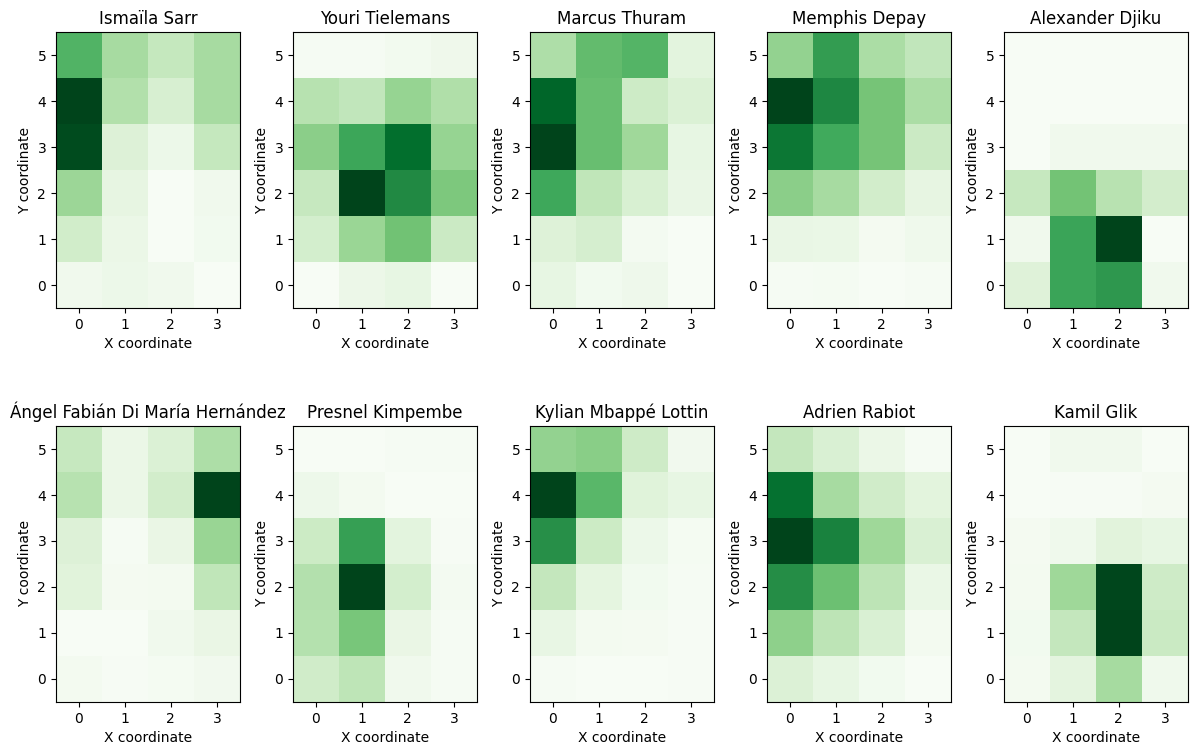

In [ ]:
import matplotlib.pyplot as plt

# Number of players to visualize
def visualize_players(heatmaps, ids, file_name = ""):   
    num_players = 10
    rows, cols = 2, 5

    fig, axes = plt.subplots(rows, cols, figsize=(12, 8))
    for i in range(num_players):
        r, c = divmod(i, cols)
        ax = axes[r, c]
        ax.imshow(
            heatmaps[i],
            cmap='Greens',
            origin='lower'
        )
        
        # Get player name safely
        match = player_name[player_name["player_id"] == ids[i]]
        if not match.empty:
            name = match.iloc[0].player_name
        else:
            name = "Unknown"
        
        ax.set_title(name)
        ax.set_xlabel("X coordinate")
        ax.set_ylabel("Y coordinate")


    if (file_name != ""):
        plt.savefig(file_name)
    else:
        plt.tight_layout()
        plt.show()

visualize_players(heatmaps,ids)

In [163]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BottleneckAutoencoder(nn.Module):
    def __init__(self, latent_dim=8):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(24, 16),
            nn.ReLU(),
            nn.Linear(16, latent_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 24),
            nn.Sigmoid()  # if inputs normalized to [0,1]
        )

    def forward(self, x):
        # Flatten from [B, 1, 6, 4] → [B, 24]
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        x = self.decoder(z)
        # Reshape back to [B, 1, 6, 4]
        return x.view(x.size(0), 1, 6, 4)


In [164]:
from torch.utils.data import DataLoader, TensorDataset


dataset = TensorDataset(X)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
model = BottleneckAutoencoder(latent_dim=8).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

for epoch in range(50):
    for batch in dataloader:
        inputs = batch[0].to(device)
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.6f}")


cpu
Epoch 1, Loss: 0.137905
Epoch 2, Loss: 0.153144
Epoch 3, Loss: 0.126229
Epoch 4, Loss: 0.109999
Epoch 5, Loss: 0.096108
Epoch 6, Loss: 0.085488
Epoch 7, Loss: 0.087615
Epoch 8, Loss: 0.079076
Epoch 9, Loss: 0.084365
Epoch 10, Loss: 0.068788
Epoch 11, Loss: 0.072966
Epoch 12, Loss: 0.077903
Epoch 13, Loss: 0.082165
Epoch 14, Loss: 0.071116
Epoch 15, Loss: 0.065752
Epoch 16, Loss: 0.066778
Epoch 17, Loss: 0.058567
Epoch 18, Loss: 0.055979
Epoch 19, Loss: 0.043419
Epoch 20, Loss: 0.054636
Epoch 21, Loss: 0.036764
Epoch 22, Loss: 0.034022
Epoch 23, Loss: 0.037746
Epoch 24, Loss: 0.046614
Epoch 25, Loss: 0.041826
Epoch 26, Loss: 0.036496
Epoch 27, Loss: 0.027248
Epoch 28, Loss: 0.020815
Epoch 29, Loss: 0.017215
Epoch 30, Loss: 0.027911
Epoch 31, Loss: 0.019678
Epoch 32, Loss: 0.020360
Epoch 33, Loss: 0.031126
Epoch 34, Loss: 0.021434
Epoch 35, Loss: 0.019914
Epoch 36, Loss: 0.022023
Epoch 37, Loss: 0.020401
Epoch 38, Loss: 0.014491
Epoch 39, Loss: 0.022288
Epoch 40, Loss: 0.020317
Epoch

In [165]:
model.eval()
with torch.no_grad():
    recon = model(inputs).cpu()


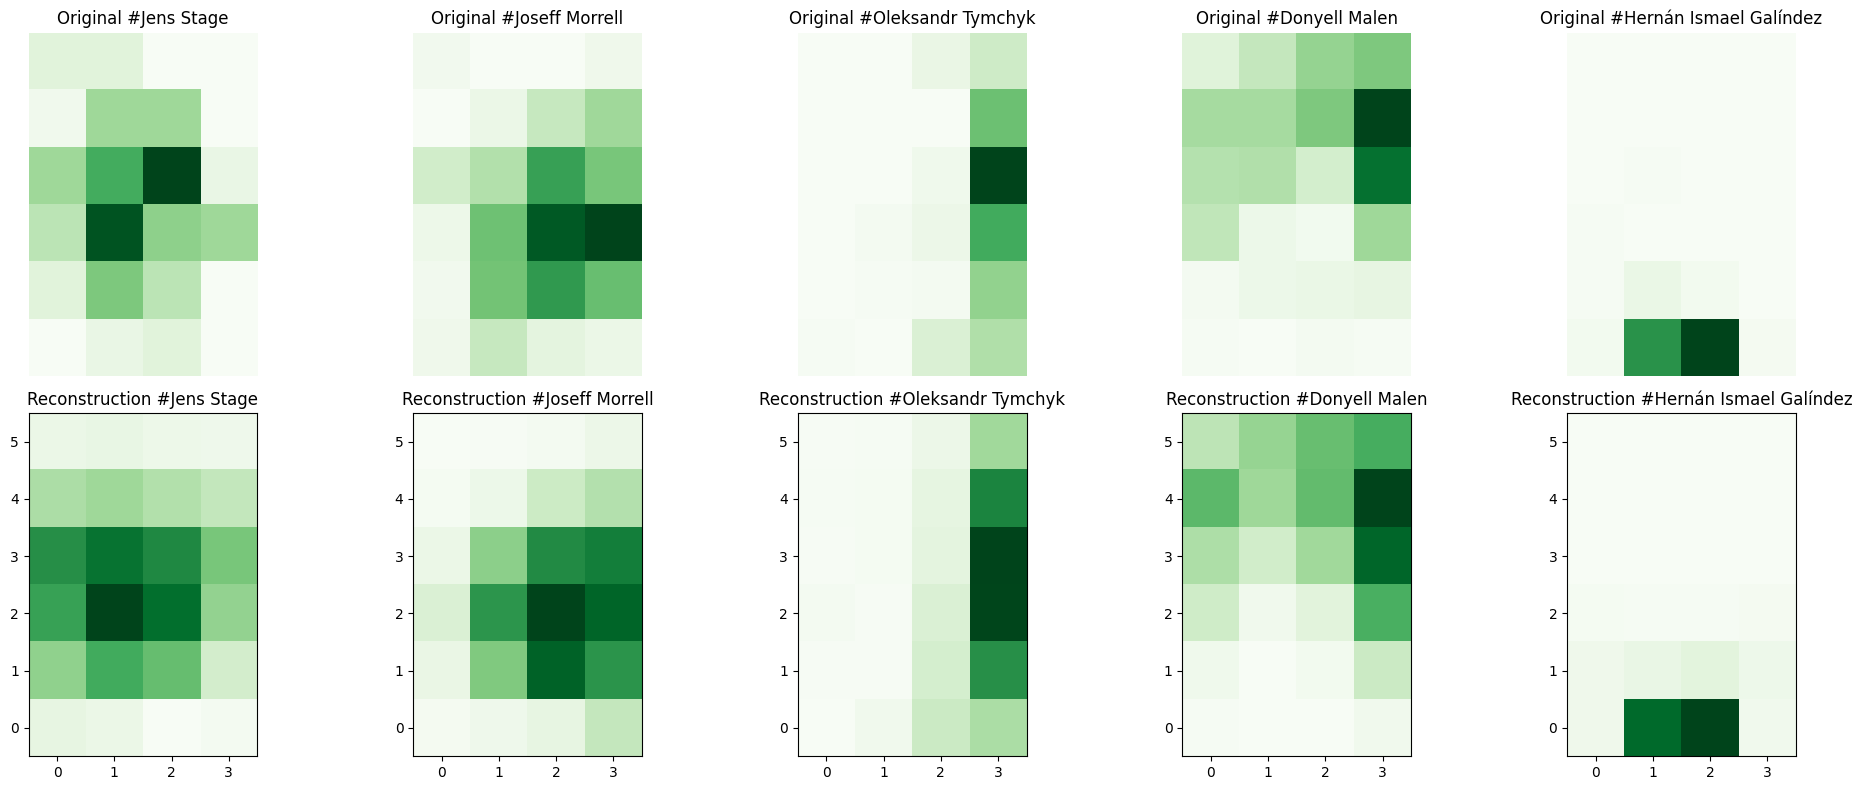

In [166]:
import matplotlib.pyplot as plt
import numpy as np
import torch

indices = np.random.choice(len(X), size=5, replace=False)

# Get reconstructions
model.eval()
with torch.no_grad():
    inputs = X[indices].to(device)
    recons = model(inputs).cpu()

fig, axes = plt.subplots(2, 5, figsize=(20, 8))

for i in range(5):
    row = 0 if i < 5 else 1   # first 5 originals in row 0, next 5 reconstructions in row 1
    col = i % 5

    axes[0, col].imshow(inputs[i,0].cpu(), cmap='Greens', origin='lower')
    axes[0, col].set_title(f"Original #{player_name[player_name["player_id"] == ids[indices[i]]].iloc[0].player_name}")
    axes[1, col].imshow(recons[i,0], cmap='Greens', origin='lower')
    axes[1, col].set_title(f"Reconstruction #{player_name[player_name["player_id"] == ids[indices[i]]].iloc[0].player_name}")
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()


# Player level aggregation


In [167]:
print(", ".join(df_event.columns.to_list()))
df_event['sub_type_name'].unique()
df_event['body_part_name'].unique()
df_event[df_event['type_name'] == "Dribble"]['outcome_name'].unique()
#df_event[df_event['type_name'] == "Shot"]['shot_first_time'].unique()


id, index, period, timestamp, minute, second, possession, duration, match_id, type_id, type_name, possession_team_id, possession_team_name, play_pattern_id, play_pattern_name, team_id, team_name, tactics_formation, player_id, player_name, position_id, position_name, pass_recipient_id, pass_recipient_name, pass_length, pass_angle, pass_height_id, pass_height_name, end_x, end_y, body_part_id, body_part_name, sub_type_id, sub_type_name, x, y, under_pressure, outcome_id, outcome_name, counterpress, out, aerial_won, off_camera, pass_switch, pass_cross, shot_statsbomb_xg, shot_first_time, technique_id, technique_name, goalkeeper_position_id, goalkeeper_position_name, pass_assisted_shot_id, pass_shot_assist, end_z, shot_key_pass_id, injury_stoppage_in_chain, foul_won_defensive, ball_recovery_recovery_failure, foul_committed_advantage, foul_won_advantage, pass_deflected, block_deflection, foul_committed_penalty, foul_won_penalty, foul_committed_card_id, foul_committed_card_name, block_save_blo

array(['Incomplete', 'Complete'], dtype=object)

In [168]:
df_pressure = df_event.groupby(['player_id'])['under_pressure'].sum().reset_index()
df_pressure.rename(columns={'under_pressure': 'pressure_count'}, inplace=True)

# Count event types 
df_counts = df_event.groupby(['player_id'])['type_name'].value_counts().unstack(fill_value=0).reset_index()
df_counts = df_counts[['player_id', 'Pass', 'Carry', 'Dribble', 'Shot', 'Duel', 'Pressure', 'Block', 'Ball Recovery', 'Interception', 'Clearance', 'Foul Won', 'Foul Committed']].fillna(0)

df_position_groups = df_event.groupby(['player_id'])['pos_group'].value_counts(normalize=True).unstack(fill_value=0).reset_index()


# Passes

df_pass = df_event[(df_event['type_name'] == 'Pass')].groupby(['player_id']).agg(
    all_passes = ('pass_length', 'count'),
    successful_passes = ('outcome_name', lambda x: (x.isin([np.nan, 'Complete', 'Success', 'Success In Play', 'Success To Team'])).sum()),
    avg_pass_length = ('pass_length', 'mean'),
    avg_pass_angle = ('pass_angle', 'mean'),
    median_pass_length = ('pass_length', 'median'),
    longest_forward_pass = ('progression', 'max'),
    pass_switch = ('pass_switch', 'count'),
    pass_cut_back = ('pass_cut_back', 'count')
).reset_index()
df_pass['pass_success_rate'] = df_pass['successful_passes'] / df_pass['all_passes']
df_pass.fillna(0, inplace=True)

df_pass_types = df_event[df_event['type_name'] == 'Pass'].groupby(['player_id'])['pass_height_name'].value_counts(normalize=True).unstack(fill_value=0).reset_index()
df_pass_types.columns = ['player_id'] + [f'{col.lower().replace(" ", "_")}' for col in df_pass_types.columns[1:]]

# Shots

df_shot = df_event[(df_event['type_name'] == 'Shot')].groupby(['player_id']).agg(
    all_shots = ('id', 'count'),
    shot_mean_length = ('x', 'mean'),
    shot_median_length = ('x', 'median'),
    headers = ('body_part_name', lambda x: (x.isin(['Head'])).sum()),
    extra_shots = ('technique_name', lambda x: (~x.isin(['Normal'])).sum()),
    first_time_shots = ('shot_first_time', 'count'),
    total_xg = ('shot_statsbomb_xg', 'sum')
)
df_shot.fillna(0, inplace=True)


# Dribbles
df_event['forward'] = df_event["x"] - df_event["end_x"]
df_event['vertical'] = abs(df_event["y"] - df_event["end_y"])

df_dribble = df_event[(df_event['type_name'] == 'Dribble')].groupby(['player_id']).agg(
    all_dribbles = ('id', 'count'),
    successful_dribbles_count = ('outcome_name', lambda x: (x.isin(['Complete'])).sum()),
    dribble_length_forward = ('forward', 'mean'),
    median_dribble_length_forward =  ('forward', 'median'),
    dribble_length_vertical =  ('vertical', 'mean'),
    dribble_start_x = ('x', 'mean')
)
df_dribble['successful_dribbles'] = df_dribble['successful_dribbles_count'] / df_dribble['all_dribbles']
df_dribble.fillna(0, inplace=True)



# Aggregate movement features
df_movement = df_event.groupby(['player_id']).agg(
    total_distance=('distance', 'sum'),
    avg_progression=('progression', 'mean'),
    avg_directness=('directness', 'mean'),
    total_width_change=('width_change', 'sum'),
).reset_index()



# Aggregate pitch zone counts (start zones)
df_pitch_zones = df_event.groupby(['player_id'])['start_zone'].value_counts(normalize=True).unstack(fill_value=0).reset_index()
df_pitch_zones.columns = ['player_id'] + [f'start_{col.lower().replace(" ", "_")}' for col in df_pitch_zones.columns[1:]]

# Aggregate pitch zone counts (end zones)
df_pitch_zones_end = df_event.groupby(['player_id'])['end_zone'].value_counts(normalize=True).unstack(fill_value=0).reset_index()
df_pitch_zones_end.columns = ['player_id'] + [f'end_{col.lower().replace(" ", "_")}' for col in df_pitch_zones_end.columns[1:]]


# Pressure & support
df_pressure_support = df_event.groupby(['player_id']).agg(
    avg_opponent_distance = ('opponent_distance', 'mean'),
    avg_teammate_distance = ('teammate_distance', 'mean'),
    avg_opponent_count = ('nearby_opponents', 'mean'),
    avg_teammate_count = ('nearby_teammates', 'mean'),
    avg_advanced_players = ('teammate_behind_ball', 'mean')
    ).reset_index()

# Packing
df_packing = df_event.groupby(['player_id']).agg(
    total_packing=('packing', 'sum')).reset_index()


df_counterpress = df_event.groupby(['player_id'])['counterpress'].sum().reset_index()
df_counterpress.rename(columns={'counterpress': 'counterpress_count'}, inplace=True)


df_aerial_duels = df_event.groupby(['player_id'])['aerial_won'].sum().reset_index()
df_aerial_duels.rename(columns={'aerial_won': 'aerial_duels_won'}, inplace=True)

df_duration = df_event.groupby(['player_id']).agg(avg_duration=('duration', 'mean')).reset_index()


# Merge all aggregated data into a possession-level DataFrame
player_features = df_counts \
    .merge(df_pass, on=['player_id'], how='left') \
    .merge(df_shot, on=['player_id'], how='left') \
    .merge(df_dribble, on=['player_id'], how='left') \
    .merge(df_pressure, on=['player_id'], how='left') \
    .merge(df_movement, on=['player_id'], how='left') \
    .merge(df_pass_types, on=['player_id'], how='left') \
    .merge(df_position_groups, on=['player_id'], how='left') \
    .merge(df_pitch_zones, on=['player_id'], how='left') \
    .merge(df_pitch_zones_end, on=['player_id'], how='left') \
    .merge(df_counterpress[['player_id', 'counterpress_count']], on=['player_id'], how='left') \
    .merge(df_aerial_duels[['player_id', 'aerial_duels_won']], on=['player_id'], how='left') \
    .merge(df_duration[['player_id', 'avg_duration']], on=['player_id'], how='left') \
    .merge(df_pressure_support, on=['player_id'], how='left') \
    .merge(df_packing, on=['player_id'], how='left')

# Fill NaN values with 0 where needed
player_features.fillna(0, inplace=True)
possession_features_original = player_features.copy()


In [169]:
player_features

,player_id,Pass,Carry,Dribble,Shot,Duel,Pressure,Block,Ball Recovery,Interception,...,end_middle_right,counterpress_count,aerial_duels_won,avg_duration,avg_opponent_distance,avg_teammate_distance,avg_opponent_count,avg_teammate_count,avg_advanced_players,total_packing
0,2941.0,81,102,13,10,13,51,4,17,3,...,0.212371,16.0,8,1.071278,11.914269,17.501033,1.725061,0.644769,0.0,230.0
1,2954.0,392,326,6,6,15,85,17,17,6,...,0.102964,40.0,4,1.148662,6.471326,10.684369,1.753202,0.754056,0.0,803.0
2,2972.0,103,115,12,14,17,73,9,13,4,...,0.215815,18.0,20,1.028808,10.172401,15.386319,2.136015,0.756705,0.0,259.0
3,2988.0,470,420,37,40,25,169,10,36,4,...,0.154306,58.0,7,1.102461,10.042395,15.385169,2.275938,0.741722,0.0,1104.0
4,2989.0,27,19,1,0,1,5,1,3,4,...,0.064516,6.0,2,0.994373,9.225803,12.188563,1.117647,1.082353,0.0,54.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2405,482093.0,9,11,0,1,3,19,2,2,3,...,0.000000,4.0,0,0.642968,4.697784,8.624944,2.254237,1.830508,0.0,16.0
2406,482153.0,19,16,1,2,1,6,2,5,0,...,0.153846,2.0,0,1.105668,3.090341,7.723644,2.530612,1.387755,0.0,34.0
2407,482154.0,71,83,7,2,10,86,4,19,1,...,0.207595,18.0,True,0.957230,7.533779,13.580024,1.614334,0.767918,0.0,144.0
2408,482155.0,6,7,0,1,0,7,0,1,0,...,0.000000,3.0,True,0.930089,3.035689,8.243518,2.562500,1.343750,0.0,25.0


In [170]:
columns_to_convert = [ 'pass_switch', 'pass_cut_back', 'aerial_duels_won']

for col in columns_to_convert:
    player_features[col] = player_features[col].astype(float)

In [171]:
player_features.columns

Index(['player_id', 'Pass', 'Carry', 'Dribble', 'Shot', 'Duel', 'Pressure',
       'Block', 'Ball Recovery', 'Interception', 'Clearance', 'Foul Won',
       'Foul Committed', 'all_passes', 'successful_passes', 'avg_pass_length',
       'avg_pass_angle', 'median_pass_length', 'longest_forward_pass',
       'pass_switch', 'pass_cut_back', 'pass_success_rate', 'all_shots',
       'shot_mean_length', 'shot_median_length', 'headers', 'extra_shots',
       'first_time_shots', 'total_xg', 'all_dribbles',
       'successful_dribbles_count', 'dribble_length_forward',
       'median_dribble_length_forward', 'dribble_length_vertical',
       'dribble_start_x', 'successful_dribbles', 'pressure_count',
       'total_distance', 'avg_progression', 'avg_directness',
       'total_width_change', 'ground_pass', 'high_pass', 'low_pass',
       'Center Back', 'Center Midfield', 'Goalkeeper', 'Striker', 'Wide Back',
       'Wide Midfield', 'start_attacking_center', 'start_attacking_left',
       'start_att

In [172]:
from sql_schemas import PlayingTimes, Competitions
from db_connection import get_db
from sqlalchemy import text

db = next(get_db())
playing_times = db.query(PlayingTimes).all()
db.close()
df = pd.DataFrame([vars(r) for r in playing_times]).drop(columns="_sa_instance_state")
df
total_minutes_df = df.groupby(["player_id"])["minutes"].sum().reset_index()
total_minutes_df
names_df = df.groupby(["player_id"])["player_name"].min().reset_index()
player_features = player_features.merge(total_minutes_df, on=['player_id'], how='left')
player_features = player_features.merge(names_df, on=['player_id'], how='left')

In [173]:
player_features.to_excel('../../excel/player_features.xlsx', index=False)

In [174]:
player_features = pd.read_excel('../../excel/player_features.xlsx')
player_features = player_features[player_features['minutes'] > 200]
player_features.reset_index(drop=True, inplace=True)

In [175]:
import pandas as pd

# Wide Focus = Width-related features (Summing all start & end width-related positions)
player_features["wide_focus"] = (
    player_features["start_attacking_left"] +
    player_features["start_attacking_right"] +
    player_features["start_middle_left"] +
    player_features["start_middle_right"] +
    player_features["start_defensive_left"] +
    player_features["start_defensive_right"] +
    player_features["end_attacking_left"] +
    player_features["end_attacking_right"] +
    player_features["end_middle_left"] +
    player_features["end_middle_right"] +
    player_features["end_defensive_left"] +
    player_features["end_defensive_right"]
)

player_features["defensive_start"] = (
    player_features["start_defensive_left"] +
    player_features["start_defensive_right"] +
    player_features["start_defensive_center"]
)
player_features["middle_start"] = (
    player_features["start_middle_left"] +
    player_features["start_middle_right"] +
    player_features["start_middle_center"]
)
player_features["attacking_start"] = (
    player_features["start_attacking_left"] +
    player_features["start_attacking_right"] +
    player_features["start_attacking_center"]
)



In [176]:

per90_columns = ['Pass', 'Carry', 'Dribble', 'Shot', 'Duel', 'Pressure',
       'Block', 'Ball Recovery', 'Interception', 'Clearance', 'Foul Won',
       'Foul Committed', 'pass_switch', 'pass_cut_back', 'shot_mean_length',
       'headers', 'extra_shots', 'total_xg',
       'successful_dribbles', 'pressure_count',
       'total_distance', 'total_width_change', 'counterpress_count',
       'aerial_duels_won', 'total_packing', 'wide_focus']
player_features[per90_columns] = player_features[per90_columns].div(player_features["minutes"], axis=0) * 90


player_features.to_excel('../../excel/player_features_p90.xlsx', index=False)

In [177]:

# Dropping original columns to avoid redundancy
features_to_drop = [
    # Wide Focus Components
    "start_attacking_left", "start_attacking_right", "start_middle_left", "start_middle_right", "start_defensive_left", "start_defensive_right",
    "start_attacking_center", "start_defensive_center", "start_middle_center",
    "end_attacking_left", "end_attacking_right", "end_middle_left", "end_middle_right", "end_defensive_left", "end_defensive_right",
    "end_attacking_center", "end_defensive_center", "end_middle_center",
    'all_passes', 'successful_passes','all_shots',
    # Highly Correlated Features
    #"ground_pass","total_width_change", "successful_passes", "pressure_count","all_passes", "total_distance",
    #"total_width_change", "total_packing", "total_duration", "wide_focus", "defensive_intensity", "on_ball_actions", "defensive_actions"
    # 'avg_directness','low_pass', 'Shot',
    #   'pass_switch', 'pass_cut_back', 'aerial_duels_won', 'defensive_start', 'middle_start'
]
player_features_dr = player_features.drop(columns=features_to_drop)

In [178]:
player_features_dr = player_features_dr[player_features_dr['minutes'] > 200]
player_features_dr

,player_id,Pass,Carry,Dribble,Shot,Duel,Pressure,Block,Ball Recovery,Interception,...,avg_opponent_count,avg_teammate_count,avg_advanced_players,total_packing,minutes,player_name,wide_focus,defensive_start,middle_start,attacking_start
0,2941,7.915309,9.967427,1.270358,0.977199,1.270358,4.983713,0.390879,1.661238,0.293160,...,1.725061,0.644769,0,22.475570,921,Ismaïla Sarr,0.135599,0.084536,0.340206,0.575258
1,2954,25.695557,21.369264,0.393299,0.393299,0.983248,5.571741,1.114348,1.114348,0.393299,...,1.753202,0.754056,0,52.636562,1373,Youri Tielemans,0.048932,0.202808,0.606864,0.190328
2,2972,4.753846,5.307692,0.553846,0.646154,0.784615,3.369231,0.415385,0.600000,0.184615,...,2.136015,0.756705,0,11.953846,1950,Marcus Thuram,0.046458,0.079077,0.449753,0.471170
3,2988,16.504097,14.748342,1.299259,1.404604,0.877877,5.934452,0.351151,1.264144,0.140460,...,2.275938,0.741722,0,38.767070,2563,Memphis Depay,0.032563,0.036336,0.417123,0.546541
4,2989,6.000000,4.222222,0.222222,0.000000,0.222222,1.111111,0.222222,0.666667,0.888889,...,1.117647,1.082353,0,12.000000,405,Alexander Djiku,0.088411,0.698925,0.301075,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1932,460753,10.329341,8.982036,0.538922,0.538922,1.706587,8.263473,0.808383,2.514970,0.269461,...,1.568539,0.797753,0,24.341317,1002,Iman Beney,0.134559,0.278626,0.391221,0.330153
1933,463543,3.580470,2.115732,0.000000,0.000000,0.650995,3.254973,0.976492,0.325497,0.162749,...,1.543210,1.049383,0,11.555154,553,Nea Lehtola,0.224828,0.278351,0.360825,0.360825
1934,482153,3.269598,2.753346,0.172084,0.344168,0.172084,1.032505,0.344168,0.860421,0.000000,...,2.530612,1.387755,0,5.850860,523,Milena Kokosz,0.161494,0.169231,0.676923,0.153846
1935,482154,17.270270,20.189189,1.702703,0.486486,2.432432,20.918919,0.972973,4.621622,0.243243,...,1.614334,0.767918,0,35.027027,370,Paulina Tomasiak,0.362094,0.336709,0.427848,0.235443


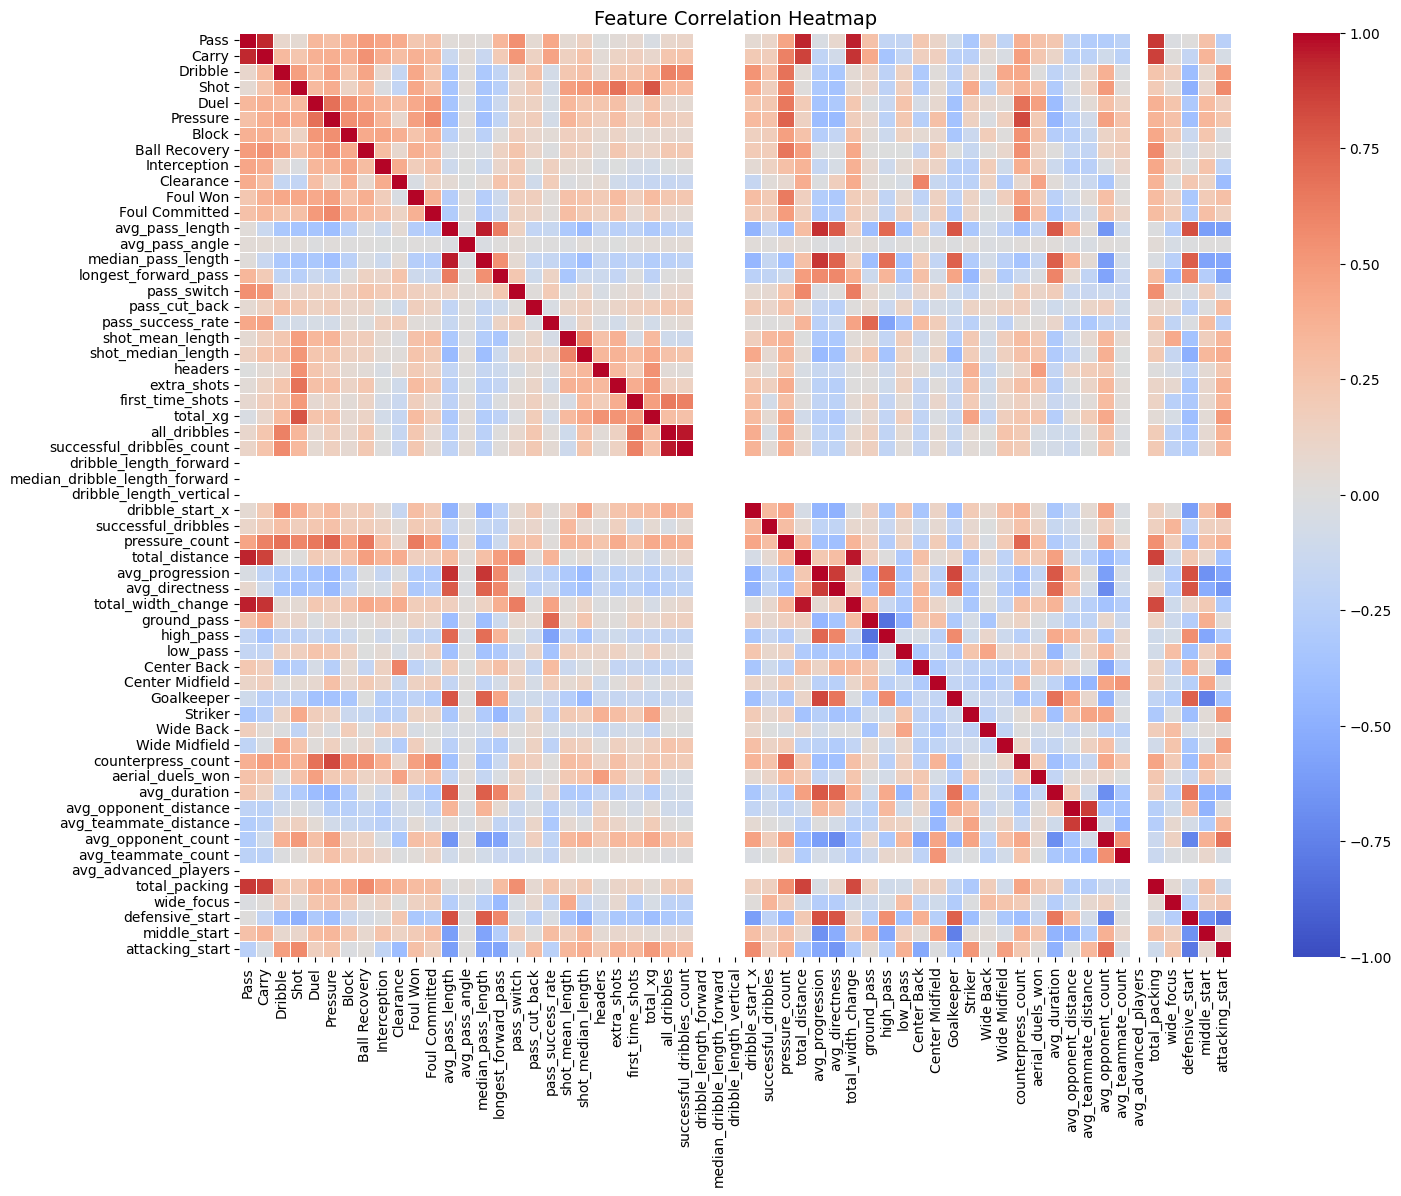

Highly correlated feature pairs (correlation > 0.80):
Carry and Pass: 0.94
median_pass_length and avg_pass_length: 0.96
successful_dribbles_count and all_dribbles: 0.97
total_distance and Pass: 0.94
total_distance and Carry: 0.85
avg_progression and avg_pass_length: 0.91
avg_progression and median_pass_length: 0.89
avg_directness and avg_progression: 0.88
total_width_change and Pass: 0.95
total_width_change and Carry: 0.90
total_width_change and total_distance: 0.96
high_pass and ground_pass: 0.82
Goalkeeper and avg_progression: 0.84
counterpress_count and Pressure: 0.83
avg_teammate_distance and avg_opponent_distance: 0.88
total_packing and Pass: 0.89
total_packing and Carry: 0.86
total_packing and total_distance: 0.85
total_packing and total_width_change: 0.83
defensive_start and avg_pass_length: 0.81
defensive_start and avg_progression: 0.81


In [186]:
import seaborn as sns
import matplotlib.pyplot as plt

non_numeric_cols = ['player_id', 'player_name', 'minutes']

df_numeric = player_features_dr.drop(columns=non_numeric_cols, errors='ignore')
corr_matrix = df_numeric.corr()
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", center=0, linewidths=0.5, vmin=-1, vmax=1)
plt.title("Feature Correlation Heatmap", fontsize=14)
plt.show()

corr_matrix = df_numeric.corr().abs()
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

high_corr_pairs = [
    (col, row, upper_triangle.loc[row, col])
    for col in upper_triangle.columns
    for row in upper_triangle.index
    if upper_triangle.loc[row, col] > 0.80
]

if high_corr_pairs:
    print("Highly correlated feature pairs (correlation > 0.80):")
    for col1, col2, corr_value in high_corr_pairs:
        print(f"{col1} and {col2}: {corr_value:.2f}")
else:
    print("No feature pairs with correlation greater than 0.80.")


In [187]:
model.eval()
latent_list = []

with torch.no_grad():
    for hm in heatmaps:
        x = torch.tensor(hm, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # [1,1,6,4]
        z = model.encoder(x.view(1, -1))  # [1, latent_dim]
        latent_list.append(z.squeeze(0).numpy())

latent_array = np.vstack(latent_list)  # shape: [N, latent_dim]

In [188]:
latent_df = pd.DataFrame(latent_array, columns=[f"latent_{i}" for i in range(latent_array.shape[1])])

df_numeric = pd.concat([df_numeric.reset_index(drop=True), latent_df], axis=1)


In [189]:
position_columns = ['Goalkeeper','Center Back', 'Wide Back', 'Center Midfield', 'Wide Midfield', 'Striker']
"""
df_numeric = df_numeric.loc[
    :, 
    [col for col in df_numeric.columns if col.startswith("latent_") or col in position_columns]
]
"""

'\ndf_numeric = df_numeric.loc[\n    :, \n    [col for col in df_numeric.columns if col.startswith("latent_") or col in position_columns]\n]\n'

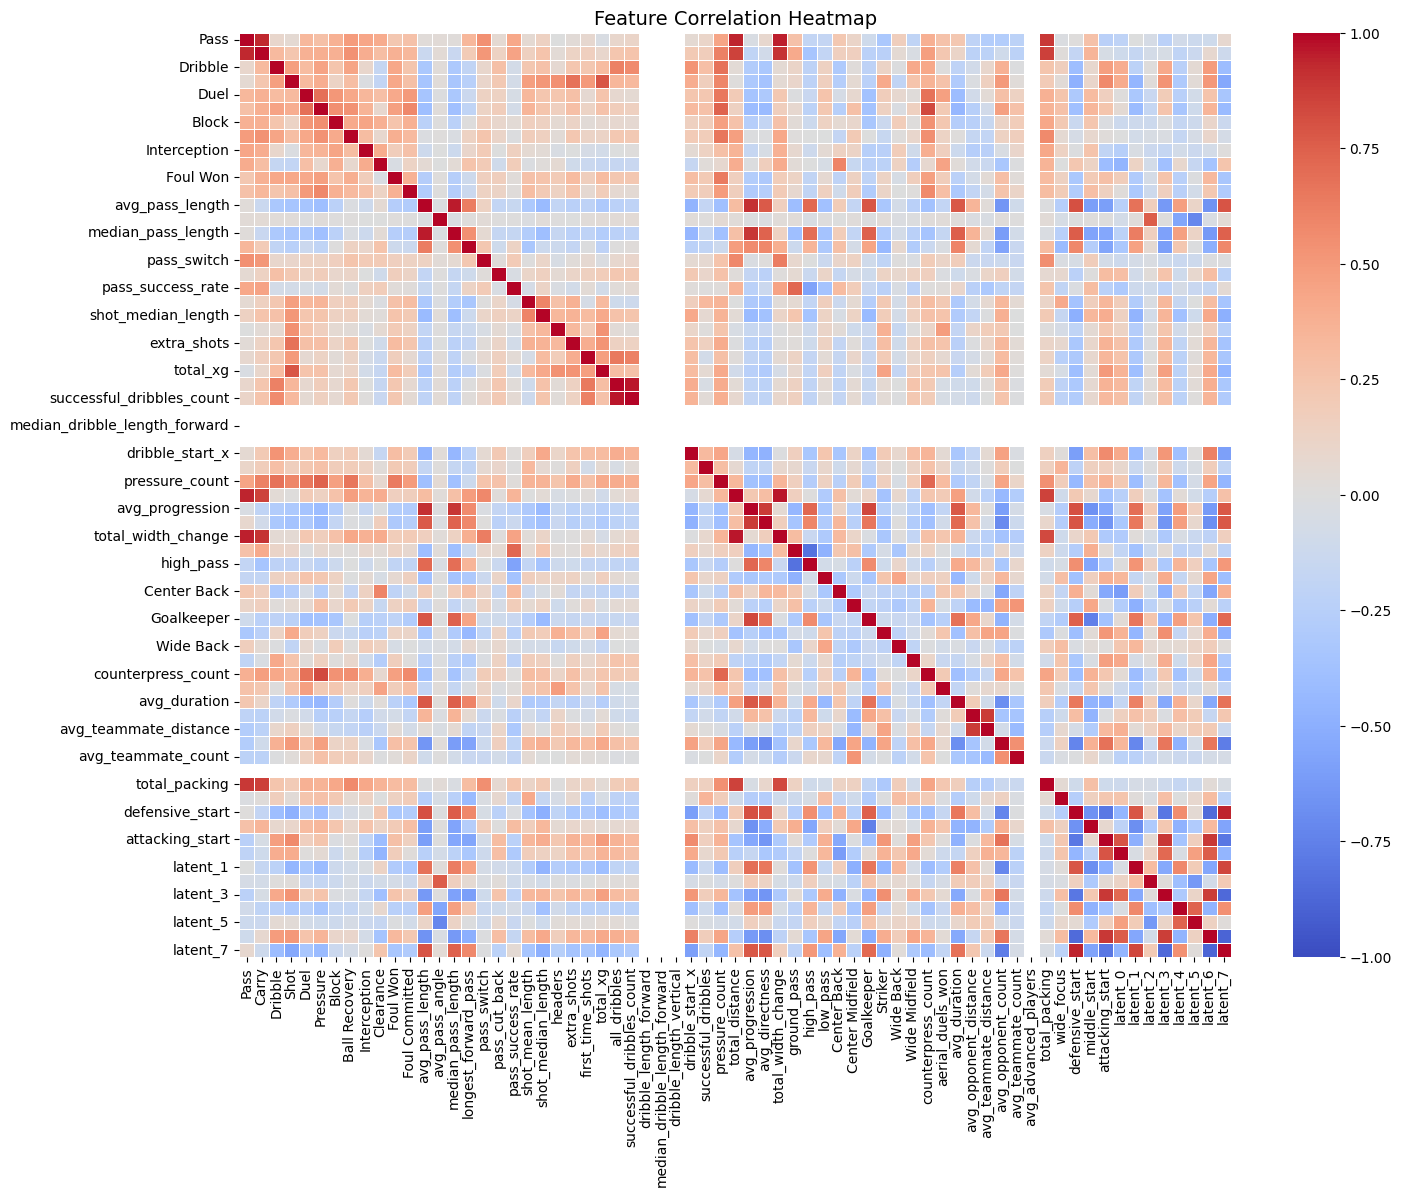

In [190]:
corr_matrix = df_numeric.corr()
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", center=0, linewidths=0.5, vmin=-1, vmax=1)
plt.title("Feature Correlation Heatmap", fontsize=14)
plt.show()

In [191]:
from sklearn.discriminant_analysis import StandardScaler


position_columns = ['Goalkeeper','Center Back', 'Wide Back', 'Center Midfield', 'Wide Midfield', 'Striker']


def closure(arr):
    """L1-normalize rows so they sum to 1 (inplace-safe)."""
    arr = np.asarray(arr, dtype=float)
    row_sums = arr.sum(axis=1, keepdims=True)
    # avoid division by zero
    row_sums[row_sums == 0] = 1.0
    return arr / row_sums

def clr_transform(arr, pseudocount=1e-6):
    """Apply CLR row-wise. arr must be positive. Returns array of same shape."""
    arr = np.asarray(arr, dtype=float) + pseudocount
    logA = np.log(arr)
    gm = logA.mean(axis=1, keepdims=True)
    return logA - gm

def centered_log_ratio(player_df):
    part_cols = [c for c in player_df.columns if c.startswith("latent_")]
    stat_cols = [c for c in player_df.columns if not c.startswith("latent_") and c not in position_columns]
    pos_comp = closure(player_df[position_columns].values)

    pos_clr = clr_transform(pos_comp, pseudocount=1e-6)
    scaler = StandardScaler()
    part_scaled = scaler.fit_transform(player_df[part_cols])
    scaler2 = StandardScaler()
    stat_scaled = scaler2.fit_transform(player_df[stat_cols])
    # optional: weight groups (example: make positions twice as important)
    pos_weight = 1.2
    part_weight = 1.0
    stat_weight = 0.5
    pos_clr *= pos_weight
    part_scaled *= part_weight
    stat_scaled *= stat_weight

    # --- concat, scale, cluster ---
    X = np.hstack([pos_clr, part_scaled, stat_scaled])
    return X


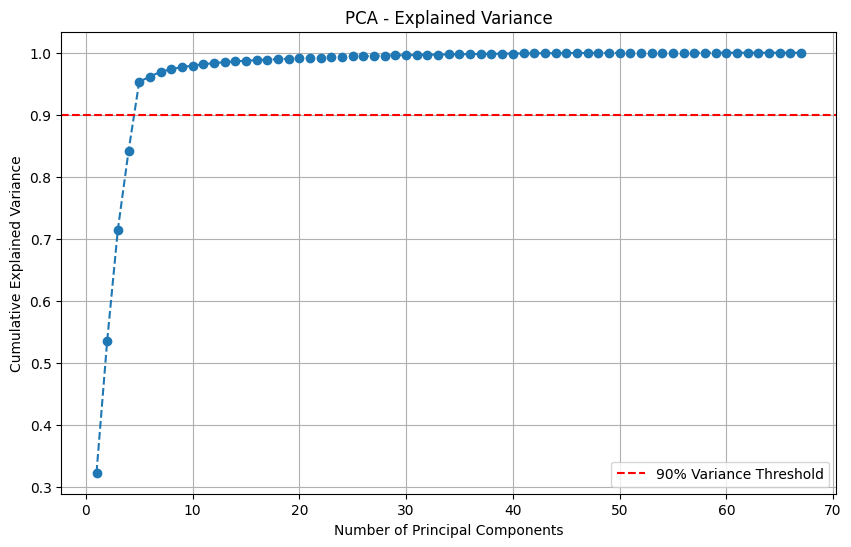

Optimal number of components: 5
PCA Feature Loadings:
               PC1       PC2       PC3       PC4       PC5
Pass      0.128254  0.062785 -0.097608 -0.229730  0.813887
Carry     0.578237  0.414200 -0.343655  0.331484 -0.285333
Dribble   0.408761 -0.401898  0.644228 -0.203161 -0.203352
Shot     -0.514214  0.617992  0.388905 -0.085295 -0.115168
Duel     -0.355967 -0.421586 -0.047197  0.712340  0.100641
...            ...       ...       ...       ...       ...
latent_3  0.007677  0.010469  0.018562  0.011686 -0.014301
latent_4 -0.001339 -0.020089  0.014791  0.008863 -0.015155
latent_5  0.029782  0.016375 -0.008046 -0.002909  0.059952
latent_6 -0.011051  0.014306  0.015164  0.009144 -0.062215
latent_7 -0.030882 -0.033810 -0.001712 -0.003642 -0.029162

[67 rows x 5 columns]


'\nsns.pairplot(\n    pca_df, \n    vars=[col for col in pca_df.columns],\n    diag_kind="kde",\n    corner=True\n)\nplt.suptitle("Pairwise PCA Component Scatter Plots", y=1.02)\nplt.show()\n'

In [192]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

scaled_features = centered_log_ratio(df_numeric)
scaled_features

position_indices = [df_numeric.columns.get_loc(c) for c in position_columns]
#scaled_features[:, position_indices] = scaled_features[:, position_indices]

# Apply PCA
pca = PCA()
pca.fit(scaled_features)

# 3️⃣ Plot Explained Variance
explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.axhline(y=0.90, color='r', linestyle='--', label='90% Variance Threshold')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA - Explained Variance')
plt.grid()
plt.legend()
plt.show()

n_components = np.argmax(explained_variance >= 0.90) + 1 
print(f"Optimal number of components: {n_components}")

pca_final = PCA(n_components=n_components)
pca_features = pca_final.fit_transform(scaled_features)

# Create DataFrame with PCA components
pca_df = pd.DataFrame(pca_features, columns=[f'PC{i+1}' for i in range(n_components)])


# Analyze Feature Loadings (Contribution of each feature to principal components)
loadings = pd.DataFrame(pca_final.components_.T, index=df_numeric.columns, columns=[f'PC{i+1}' for i in range(n_components)])
print("PCA Feature Loadings:")
print(loadings)

pca_df = pd.DataFrame(scaled_features, columns=df_numeric.columns)
'''
sns.pairplot(
    pca_df, 
    vars=[col for col in pca_df.columns],
    diag_kind="kde",
    corner=True
)
plt.suptitle("Pairwise PCA Component Scatter Plots", y=1.02)
plt.show()
'''

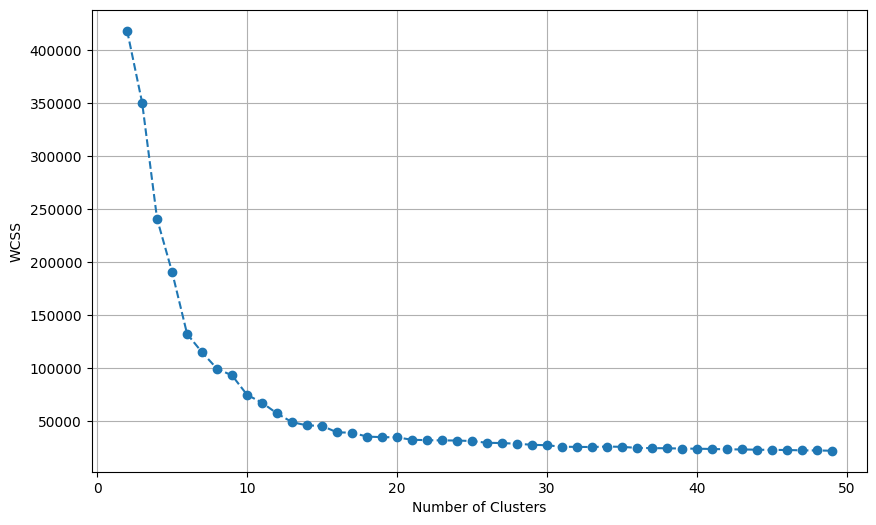

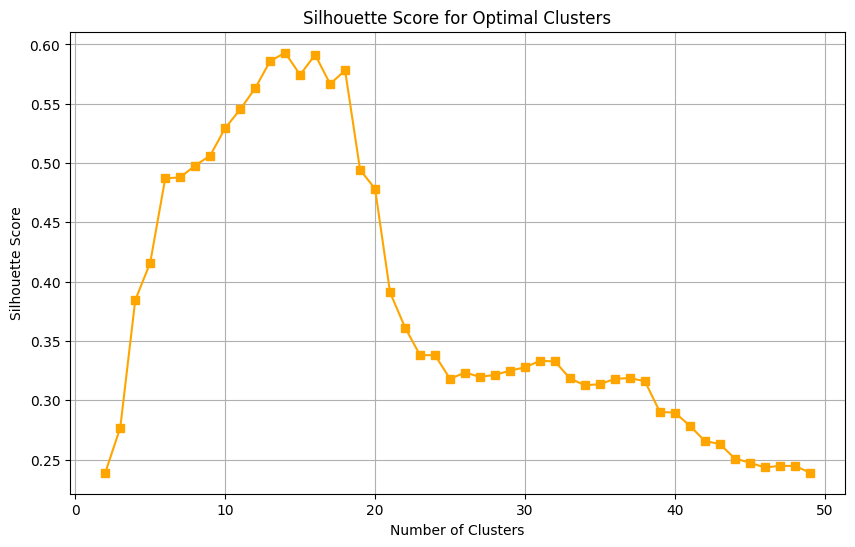

In [209]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns
import matplotlib.pyplot as plt

# Determine the optimal number of clusters using the Elbow Method
wcss = []  # Within-cluster sum of squares

max_cluster_test = 50

for i in range(2, max_cluster_test):  
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(pca_df)
    wcss.append(kmeans.inertia_)

# Plotting the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(range(2, max_cluster_test), wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid()
plt.show()

# Silhouette Score to support the elbow method
silhouette_scores = []
for n_clusters in range(2, max_cluster_test):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(pca_df)
    silhouette_avg = silhouette_score(pca_df, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot Silhouette Scores
plt.figure(figsize=(10, 6))
plt.plot(range(2, max_cluster_test), silhouette_scores, marker='s', linestyle='-', color='orange')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal Clusters')
plt.grid()
plt.show()

# Apply K-Means with the optimal number of clusters (let's assume 4 based on elbow/silhouette)
optimal_clusters = 14  # Adjust this based on your elbow/silhouette plot results
kmeans_final = KMeans(
    n_clusters=optimal_clusters,
    init='k-means++',  
    n_init=50,
    max_iter=500,
    random_state=42
)

pca_df = pd.DataFrame(scaled_features, columns=df_numeric.columns)

pca_df.to_csv('../../excel/pca_df.csv', index=False)
#pca_df = df_numeric.copy()
# Predict clusters
pca_df['Cluster'] = kmeans_final.fit_predict(pca_df)



# Analyze the average feature values per cluster (to profile playing styles)
cluster_profiles = pd.concat([pca_df, df_numeric.reset_index(drop=True)], axis=1)
cluster_summary = cluster_profiles.groupby('Cluster').mean()


In [210]:
player_features["Cluster"] = pca_df['Cluster']
player_features.columns

#assert (player_features.index == pca_df.index).all(), "Row order changed!"

names_unique = df_event.loc[:,['player_id']].drop_duplicates(subset=["player_id"]).reset_index()
player_features_with_name = player_features.merge(names_unique, on="player_id", how="left")
df_player = pca_df.copy()
df_player["player_name"] = player_features_with_name["player_name"] 
#df_player.to_csv('../../excel/pca_df.csv', index=False)

In [211]:
from requests import Session
from sqlalchemy import delete
from sql_schemas import PlayerStats


def init_player_stats(db: Session, df, tableClass=PlayerStats):
    # 1️⃣ Clear existing table
    db.execute(delete(tableClass))
    db.commit()

    # 2️⃣ Rename DataFrame columns to match ORM (adjust names if needed)
    df = df.rename(columns={
        "player_id": "id",
        "Pass": "pass_90",
        "Carry": "carry_90",
        "Dribble": "dribble_90",
        "Shot": "shot_90",
        "Duel": "duel_90",
        "Pressure": "pressure_90",
        "Block": "block_90",
        "Ball Recovery": "ball_recovery_90",
        "Interception": "interception_90",
        "Clearance": "clearance_90",
        "Foul Won": "foul_won_90",
        "Foul Committed": "foul_commited_90",
        "shot_mean_length": "average_shot_length",
        "headers": "header_percent",
        "total_xg": "xg_90",
        "successful_dribbles": "dribble_percent",
        "dribble_start_x": "average_dribble_start_x",
        "ground_pass": "ground_pass_percent",
        "low_pass": "low_pass_percent",
        "high_pass": "high_pass_percent",
        "Goalkeeper": "goalkeeper",
        "Center Back": "center_back",
        "Wide Back": "wide_back",
        "Center Midfield": "center_midfielder",
        "Wide Midfield": "wide_midfielder",
        "Striker": "striker",
        "defensive_start": "defensive_start_percent",
        "middle_start": "middle_start_percent",
        "attacking_start": "attacking_start_percent",
        "Cluster" : "cluster"
    })

    orm_columns = set(c.name for c in tableClass.__table__.columns)

    df_filtered = df[[col for col in df.columns if col in orm_columns]]

    new_rows = [
        tableClass(**p)
        for p in df_filtered.to_dict(orient="records")
    ]
    db.bulk_save_objects(new_rows)
    db.commit()

In [212]:
# 1️⃣ Mapping Cluster Numbers to Style Names
cluster_to_position = {
    0: 'High long ball from defense',
    1: 'Build-up against high press',
    2: 'Set pieces or crosses close to goal',
    3: 'Regular attack transition',
    4: 'Long possession during build-up'
}

# Apply the mapping
player_features_with_name.rename(columns=cluster_to_position, inplace=True)

In [213]:
player_features_with_name.to_excel('../../excel/player_features_results.xlsx', index=False)
init_player_stats(db, player_features_with_name)


In [214]:
cluster_counts = player_features_with_name["Cluster"].value_counts().sort_index()
print(cluster_counts)

Cluster
0     292
1      77
2      68
3     105
4     295
5     141
6     122
7     220
8     121
9     113
10    159
11     69
12     47
13    108
Name: count, dtype: int64


In [215]:
pca_df['Cluster_predict'] = kmeans_final.predict(pca_df.loc[:,[x for x in pca_df.columns if x != "Cluster"]])

In [216]:
(pca_df["Cluster"] == pca_df["Cluster_predict"]).all()

np.True_

In [217]:
cluster_selected = 3

player_features_with_name[player_features_with_name["Cluster"]==cluster_selected].loc[:,["Cluster", "Goalkeeper", "Center Back", "Wide Back", "Center Midfield", "Wide Midfield", "Striker", "player_name", "minutes"]]

,Cluster,Goalkeeper,Center Back,Wide Back,Center Midfield,Wide Midfield,Striker,player_name,minutes
0,3,0,0.0,0.0,0.0,1.0,0.0,Ismaïla Sarr,921
5,3,0,0.0,0.0,0.0,1.0,0.0,Ángel Fabián Di María Hernández,750
70,3,0,0.0,0.0,0.0,1.0,0.0,Karl Brillant Toko Ekambi,411
80,3,0,0.0,0.0,0.0,1.0,0.0,Sofiane Boufal,897
120,3,0,0.0,0.0,0.0,1.0,0.0,David Brooks,239
...,...,...,...,...,...,...,...,...,...
1897,3,0,0.0,0.0,0.0,1.0,0.0,Emily Masiel Cedeño Coba,554
1904,3,0,0.0,0.0,0.0,1.0,0.0,Natalia Didelka Mills Urrunaga,234
1925,3,0,0.0,0.0,0.0,1.0,0.0,Klaudia Jedlińska,217
1926,3,0,0.0,0.0,0.0,1.0,0.0,Signe Gaupset,721


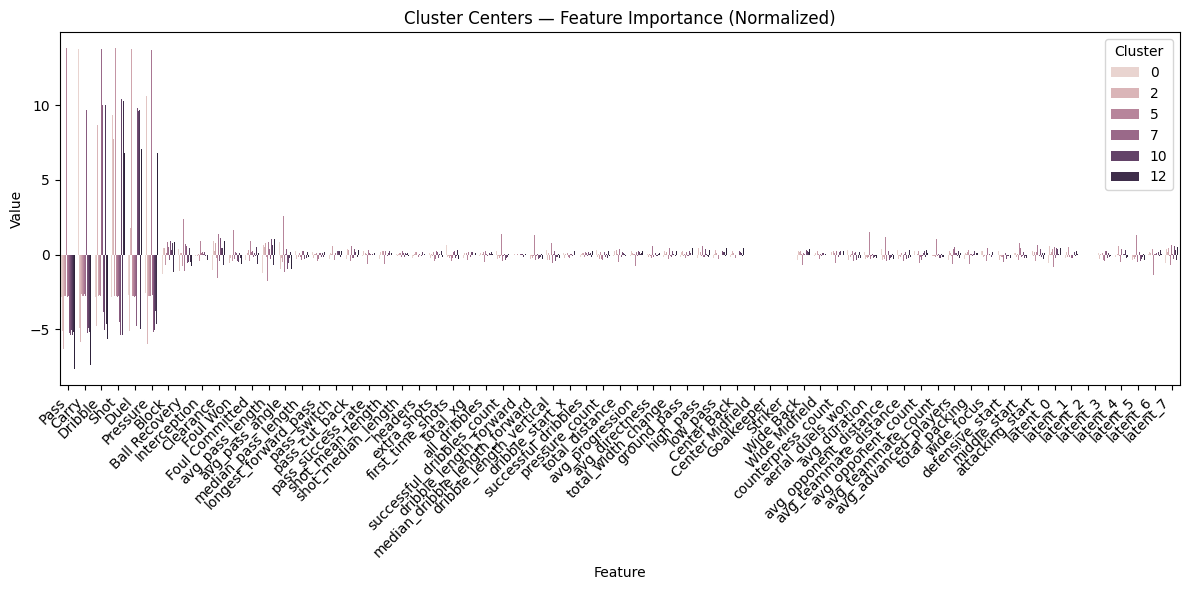

In [218]:
centers = pd.DataFrame(
    kmeans_final.cluster_centers_,
    columns=[x for x in pca_df.columns if "Cluster" not in x]
)
'''

for i, row in centers.iterrows():
    plt.figure(figsize=(10, 5))
    
    # Plot positions + parts together
    sns.barplot(x=[x for x in pca_df.columns if "Cluster" not in x], y=row.values)
    plt.title(f"Cluster {i} — Feature Importance (Normalized Center)")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()
'''
centers_long = centers.melt(ignore_index=False, var_name="Feature", value_name="Value")
centers_long = centers_long.reset_index().rename(columns={"index": "Cluster"})

plt.figure(figsize=(12, 6))
sns.barplot(data=centers_long, x="Feature", y="Value", hue="Cluster")

plt.title("Cluster Centers — Feature Importance (Normalized)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [219]:
df_numeric_cluster = df_numeric.copy()
df_numeric_cluster["Cluster"] = pca_df["Cluster"]
cluster_centers_original = (
    df_numeric_cluster.groupby("Cluster")[[x for x in pca_df.columns if "Cluster" not in x]]
      .mean()
      .reset_index()
)

print(cluster_centers_original)

    Cluster       Pass      Carry   Dribble      Shot      Duel  Pressure  \
0         0  17.294471  12.976617  0.081743  0.133524  0.976697  2.966387   
1         1   9.043081   7.924337  0.534932  0.674071  1.534683  6.290667   
2         2  13.456720  11.055969  0.512201  0.377212  1.016648  4.992855   
3         3  10.709821  11.095779  1.077441  0.618994  1.333239  7.251538   
4         4  15.859944  12.732484  0.372649  0.356892  1.217843  6.995605   
5         5  10.594583   5.394704  0.006052  0.005032  0.002980  0.037429   
6         6   7.091650   6.907795  0.572644  0.865800  1.634352  7.182834   
7         7  17.689530  12.123720  0.412854  0.197443  1.296655  5.066784   
8         8  17.658509  12.687990  0.260514  0.165301  1.145701  4.209041   
9         9   8.200840   8.403095  0.726656  0.700725  1.105934  5.794641   
10       10  13.783485  12.682446  0.730391  0.501043  1.126521  7.024708   
11       11  10.432378   8.852334  0.684800  0.329834  1.019808  5.115521   

In [220]:
pca_plot = pca_df.copy()
pca_plot["Cluster_Highlight"] = pca_plot["Cluster"].apply(
    lambda x: x == cluster_selected
)
'''
sns.pairplot(
    pca_plot, 
    vars=[col for col in pca_df.columns if col != "Cluster"],
    hue="Cluster_Highlight",
    diag_kind="kde",
    corner=True
)
'''

'\nsns.pairplot(\n    pca_plot, \n    vars=[col for col in pca_df.columns if col != "Cluster"],\n    hue="Cluster_Highlight",\n    diag_kind="kde",\n    corner=True\n)\n'

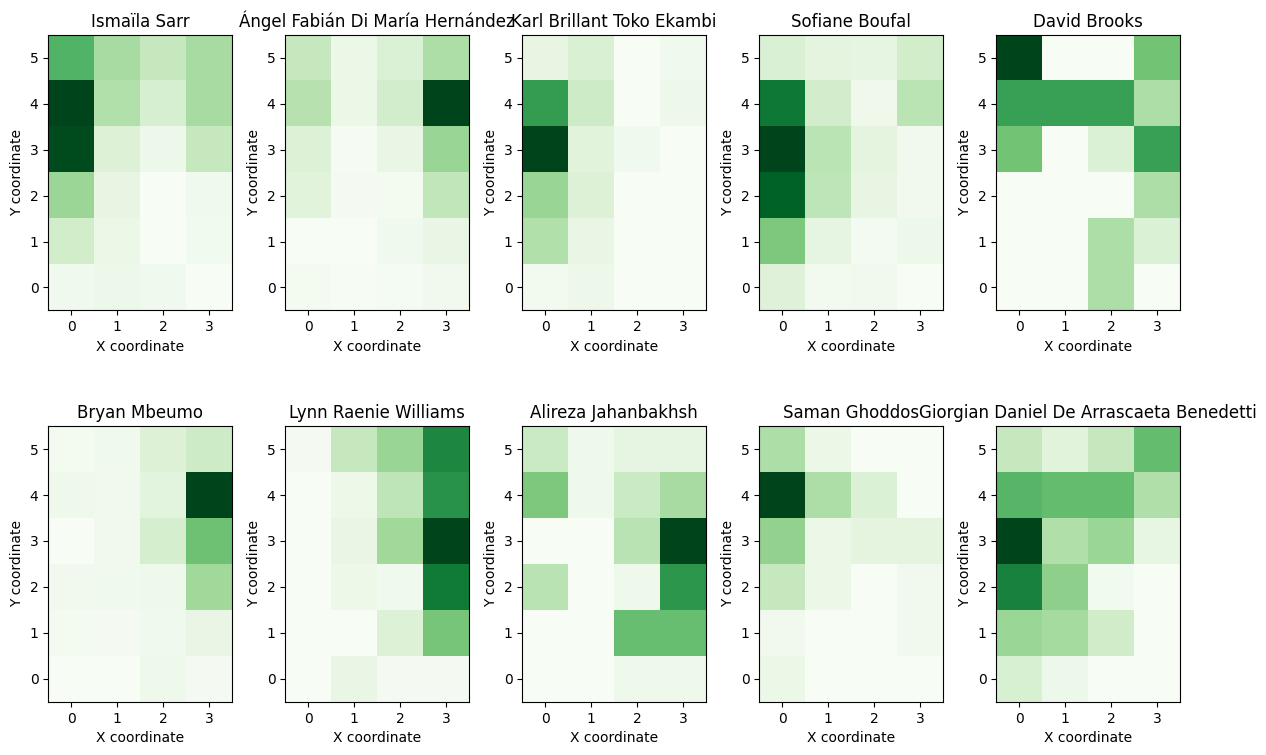

In [ ]:
cluster_ids = player_features_with_name.loc[
    player_features_with_name["Cluster"] == cluster_selected, 
    "player_id"
].unique()
filtered_ids = [i for i in ids if i in cluster_ids]
filtered_heatmaps = [
    heatmap for heatmap, pid in zip(heatmaps, ids) if pid in cluster_ids
]
visualize_players(filtered_heatmaps, filtered_ids)

for i in range(cluster_counts):
    visualize_players(filtered_heatmaps, filtered_ids, f"players_cluster_{i}")

In [222]:
a = player_features_with_name.loc[:,["Cluster", 'avg_pass_length', 'wide_focus', 'attacking_start','total_xg']].groupby(["Cluster"]).describe().T
a

Cluster                        0          1          2           3   \
avg_pass_length count  292.000000  77.000000  68.000000  105.000000   
                mean    23.140379  16.218429  18.961905   17.355970   
                std      3.027902   2.914005   2.581896    2.831573   
                min      8.639125  11.913194  14.240413   11.949125   
                25%     21.224849  14.123235  16.916701   15.179275   
                50%     22.965014  15.906929  18.582360   17.291798   
                75%     24.446847  17.847869  20.486659   19.496688   
                max     41.492744  29.012563  25.312337   25.010355   
wide_focus      count  292.000000  77.000000  68.000000  105.000000   
                mean     0.110183   0.143718   0.166391    0.312756   
                std      0.093490   0.102170   0.163061    0.143453   
                min      0.004836   0.018075   0.017822    0.055255   
                25%      0.046919   0.071423   0.055727    0.200846   
                50%      0.083895   0.109068   0.105712    0.291365   
                75%      0.139771   0.185572   0.217433    0.414201   
                max      0.627907   0.438965   0.758815    0.704545   
attacking_start count  292.000000  77.000000  68.000000  105.000000   
                mean     0.039039   0.405342   0.317369    0.419670   
                std      0.029692   0.143396   0.126232    0.155151   
                min      0.000000   0.060000   0.046512    0.035714   
                25%      0.018654   0.288889   0.227969    0.296053   
                50%      0.031279   0.413420   0.304743    0.417582   
                75%      0.051580   0.500000   0.389618    0.555921   
                max      0.197452   0.765886   0.711066    0.830189   
total_xg        count  292.000000  77.000000  68.000000  105.000000   
                mean     0.015548   0.098542   0.039980    0.059348   
                std      0.023582   0.092616   0.051542    0.079372   
                min      0.000000   0.000000   0.000000    0.000000   
                25%      0.000000   0.024077   0.005291    0.003722   
                50%      0.007017   0.086092   0.020123    0.038109   
                75%      0.020713   0.142790   0.061842    0.087589   
                max      0.167720   0.467980   0.306507    0.466238   

Cluster                        4           5           6           7   \
avg_pass_length count  295.000000  141.000000  122.000000  220.000000   
                mean    18.769415   38.702785   14.987988   19.174854   
                std      2.517028    7.732056    2.795513    2.437288   
                min     11.665403   21.260263    0.000000   13.109004   
                25%     17.328102   32.700106   13.531754   17.550666   
                50%     18.732313   38.023885   14.661577   18.996626   
                75%     20.180746   44.778888   16.691713   20.549108   
                max     28.496703   63.759710   22.771332   27.444722   
wide_focus      count  295.000000  141.000000  122.000000  220.000000   
                mean     0.143389    0.022080    0.172063    0.260817   
                std      0.098622    0.020900    0.110382    0.156061   
                min      0.006083    0.000000    0.013357    0.026585   
                25%      0.074700    0.011905    0.084726    0.143835   
                50%      0.117358    0.019494    0.151310    0.230120   
                75%      0.190902    0.026012    0.228019    0.354959   
                max      0.500818    0.167079    0.592200    0.752177   
attacking_start count  295.000000  141.000000  122.000000  220.000000   
                mean     0.213263    0.000793    0.490982    0.259883   
                std      0.112171    0.003276    0.119045    0.104484   
                min      0.000000    0.000000    0.119760    0.000000   
                25%      0.134508    0.000000    0.417512    0.189192   
                50%      0.192555    0.000000    0

In [223]:
cluster_summary.T

Cluster,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Pass,-2.816799,-5.106441,-6.354683,-2.786609,-2.767251,13.815512,-2.856807,-2.773478,-5.275914,-5.370527,-5.050714,-5.366019,-5.202070,-7.693665
Carry,13.760641,-4.953866,-5.870176,-2.640559,-2.767251,-2.763102,-2.630896,-2.773478,9.678270,-5.247670,-4.902414,-5.206097,9.181471,-7.397765
Dribble,-2.816799,-4.788964,8.678760,-2.786609,-2.742358,-2.763102,-2.509797,13.804558,10.031743,-3.864898,-5.050714,10.008646,-4.672872,-5.632525
Shot,-2.816799,9.363077,7.743188,-2.786609,13.811361,-2.763102,-2.856807,-2.773478,-4.514490,-5.370527,10.445058,-5.366019,10.320965,6.832423
Duel,-2.742586,-5.106441,1.790999,13.786996,-2.767251,-2.763102,-2.856807,-2.773478,-4.760537,9.829886,9.609499,9.683139,-4.986371,7.063291
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
latent_3,-3.502102,-1.960642,-2.485904,-2.076756,-2.855479,-3.954798,-1.569169,-2.584609,-3.036723,-1.772747,-2.337480,-2.324584,-3.222876,-1.922550
latent_4,-2.223500,-3.277677,-2.930966,-2.737974,-3.172259,-1.013499,-2.996642,-2.570386,-2.646911,-3.166514,-3.268296,-2.595597,-2.986028,-3.355137
latent_5,0.749902,1.077407,1.242869,1.415659,0.695533,2.000271,1.320842,1.358695,0.924110,1.250312,0.988213,1.599454,0.509754,1.230906
latent_6,-0.598430,1.373652,1.223541,1.471851,0.515130,-1.200856,1.548658,1.068442,0.392248,1.750208,1.303627,1.385802,-0.044602,1.788122


In [224]:
player_features['Cluster'] = pca_df['Cluster']
df_event_with_clusters = df_event.merge(
    player_features[['player_id', 'Cluster']],
    on=['player_id'],
    how='left')
df_event_with_clusters

,id,index,period,timestamp,minute,second,possession,duration,match_id,type_id,...,width_change,nearby_opponents,nearby_teammates,teammate_distance,opponent_distance,packing,teammate_behind_ball,forward,vertical,Cluster
0,221b0c8d-6386-4ae8-bb4a-a1dc98742312,5,1,00:00:03.417000,0,3,2,0.453249,3895302,30,...,0.8,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.8,6.0
1,76f95d8a-7d26-4262-a142-5be7b0cd022d,6,1,00:00:03.870000,0,3,2,NaN,3895302,42,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0
2,77809242-1460-4395-8779-94a0cfc275b1,7,1,00:00:03.870000,0,3,2,0.862528,3895302,43,...,0.3,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.3,1.0
3,ff56e821-21e9-4cef-ba2a-7eb5eb3769c6,8,1,00:00:04.732000,0,4,2,1.995802,3895302,30,...,2.6,1.0,2.0,5.384949,7.313200,0.0,0.0,23.9,2.6,1.0
4,ae74c490-d721-45ca-936f-3975b25d1c94,9,1,00:00:06.728000,0,6,2,NaN,3895302,42,...,0.0,0.0,0.0,14.625529,11.939729,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1169771,7140d822-6470-4589-ad95-8011f607c8f2,3969,2,00:51:32.609000,96,32,205,0.310845,3893793,43,...,0.5,2.0,1.0,9.966974,2.574600,0.0,0.0,-1.5,0.5,9.0
1169772,a7c3d844-b2dd-4c34-bac0-196a130fb374,3970,2,00:51:32.920000,96,32,205,0.000000,3893793,22,...,0.0,2.0,1.0,4.065569,1.380337,0.0,0.0,0.0,0.0,5.0
1169773,d48a41ab-fc5d-4678-8317-b368794089c3,3971,2,00:51:32.920000,96,32,205,0.000000,3893793,21,...,0.0,0.0,0.0,64.927564,74.209274,0.0,0.0,0.0,0.0,9.0
1169774,9752ccfb-c9f3-41d0-89ab-6436ee6a25d5,3974,2,00:55:23.531000,100,23,206,0.639094,3893793,16,...,2.4,0.0,0.0,10.282194,10.091023,1.0,0.0,-11.9,2.4,9.0
